In [1]:
import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt
from ipywidgets import interact
from ml_collections import ConfigDict
from models.ETD_KT_CM_JAX_Vectorised import *
from filters import resamplers
from filters.filter import ParticleFilter
jax.config.update("jax_platform_name", "cpu")
import metrics.ensemble as ens_metrics

Initialisation

In [2]:
signal_params = ConfigDict(KDV_params_2)
print(signal_params)

Advection_basis_name: none
E: 1
Forcing_basis_name: none
P: 1
S: 0
c_0: 0
c_1: 1
c_2: 0.0
c_3: 2.0e-05
c_4: 0.0
dt: 0.001
equation_name: KdV
initial_condition: gaussian
method: Dealiased_SETDRK4
noise_magnitude: 0.0
nx: 256
tmax: 1
xmax: 1
xmin: 0



In [3]:
ensemble_params = ConfigDict(KDV_params_2_SALT)
print(ensemble_params)

Advection_basis_name: constant
E: 10
Forcing_basis_name: none
P: 1
S: 0
c_0: 0
c_1: 1
c_2: 0.0
c_3: 2.0e-05
c_4: 0.0
dt: 0.001
equation_name: KdV
initial_condition: gaussian
method: Dealiased_SETDRK4
noise_magnitude: 0.01
nx: 256
tmax: 1
xmax: 1
xmin: 0



Next, we specify a signal, by choosing a deterministic solver, 

In [4]:
signal_params.update(E=1,method='Dealiased_ETDRK4',P=0,S=0,tmax=1,nmax=256*4)
ensemble_params.update(E=128,noise_magnitude=0.01,P=32,tmax=1,nmax=256*4)
n_filter_steps = 50# where to use?

Now we continue to define a stochastic ensemble

Now we specify the models, by calling the class.

In [5]:
signal_model = ETD_KT_CM_JAX_Vectorised(signal_params)
ensemble_model = ETD_KT_CM_JAX_Vectorised(ensemble_params)
initial_signal = initial_condition(signal_model.x, signal_params.E, signal_params.initial_condition)
# import numpy as np
# print(initial_signal.shape)
# purturbation = 0.1*jnp.sin(2*jnp.pi*signal_model.x)
# initial_signal = initial_signal + jnp.ones_like(1)*purturbation
initial_ensemble = initial_condition(ensemble_model.x, ensemble_params.E, ensemble_params.initial_condition)
available_resamplers = ", ".join(resamplers.keys())
print(available_resamplers)

I0000 00:00:1738858240.028607       1 tfrt_cpu_pjrt_client.cc:349] TfrtCpuClient created.


multinomial, systematic, no_resampling, default


In [6]:
pf_systematic = ParticleFilter(
    n_particles = ensemble_params.E,
    n_steps = 1,
    n_dim = initial_signal.shape[-1],
    forward_model = ensemble_model,
    signal_model = signal_model,
    sigma = 0.1,# this seems to be different than the sigma for the xi.
    seed = 11,
    resampling='multinomial',
    observation_locations = jnp.arange(0,256,4),
)

In [7]:
final, all = pf_systematic.run(initial_ensemble, initial_signal, signal_model.nmax) 
#Issue: the final input seems to need the entire scan length, not the Number of DA steps. 

Put in the initial condition.

In [8]:
particles =jnp.concatenate([initial_ensemble[None,...], all[0]], axis=0)
signal = jnp.concatenate([initial_signal[None,...], all[1]], axis=0)
print(f"Particles Shape: {particles.shape} is (N_da_steps+1, N_particles, N_dim)")
print(f"Signal Shape: {signal.shape} is (N_da_steps+1, 1,  N_dim)")
observations = all[2]
print(f"Observations Shape: {observations.shape} is (N_da_steps, 1,  N_dim)")
print(f"needs fixing, this should be (N_da_steps, N_obs_dim, N_dim)")

Particles Shape: (1001, 128, 256) is (N_da_steps+1, N_particles, N_dim)
Signal Shape: (1001, 1, 256) is (N_da_steps+1, 1,  N_dim)
Observations Shape: (1000, 1, 256) is (N_da_steps, 1,  N_dim)
needs fixing, this should be (N_da_steps, N_obs_dim, N_dim)


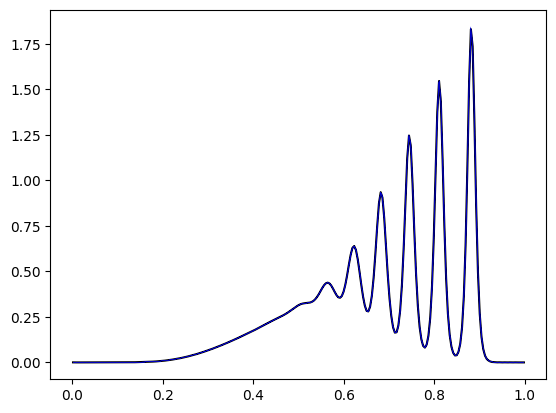

interactive(children=(IntSlider(value=500, description='da_step', max=1000), Output()), _dom_classes=('widget-…

<function __main__.plot(da_step)>

In [9]:
def plot(da_step):
    plt.plot(signal_model.x, signal[da_step,0,:], color='k',label='signal')
    plt.plot(signal_model.x, particles[da_step,:,:].T, color='b',label='particles',linewidth=0.01)
    plt.scatter(signal_model.x[::128], observations[da_step,0,:], color='r',label='observations')
    plt.show()

interact(plot, da_step=(0, signal_model.nmax))

In [10]:
bias = ens_metrics.bias(signal[1:,...], particles[1:,...])
rmse = ens_metrics.rmse(signal[1:,...], particles[1:,...])
crps = ens_metrics.crps(signal[1:,...], particles[1:,...])
print(type(bias), type(rmse), type(crps))

<class 'jaxlib.xla_extension.ArrayImpl'> <class 'jaxlib.xla_extension.ArrayImpl'> <class 'jaxlib.xla_extension.ArrayImpl'>


In [11]:
print(bias.shape, rmse.shape, crps.shape)

(1000,) (1000,) (1000,)


In [12]:
# rmse_new = ens_metrics.rmse_2(signal[1:,...], particles[1:,...])

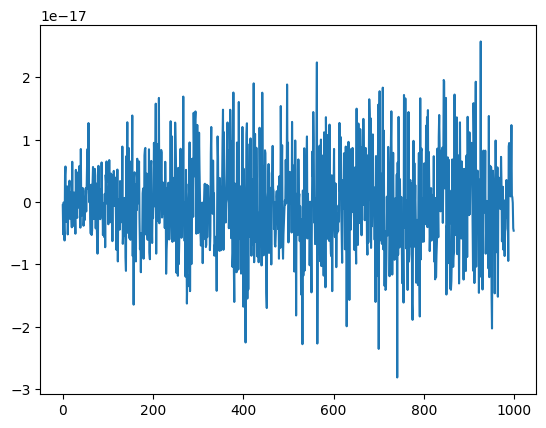

In [13]:
plt.plot(bias)
plt.show()

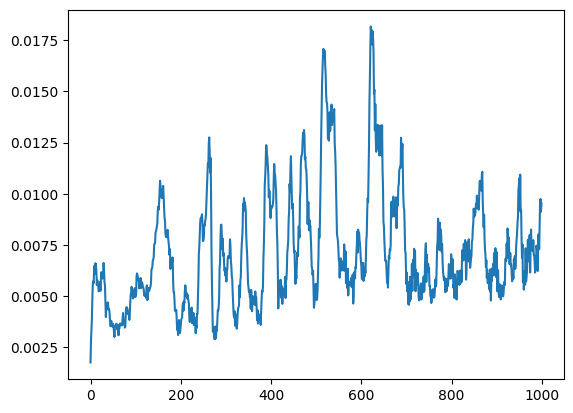

In [14]:
plt.plot(rmse)
plt.show()

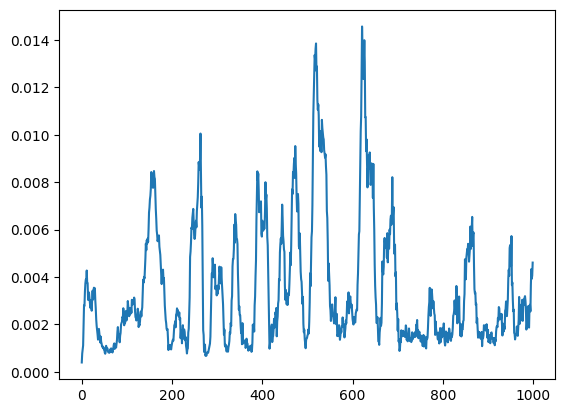

In [15]:
plt.plot(crps)
plt.show()